In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
!pip install transformers
from transformers import AutoModel, AutoTokenizer
from torch import cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_train (1).csv', delimiter='\t', names=['text','label','nan'])
train = train.drop(columns=['nan'])
# train['label'].value_counts()
# train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-malayalam':4}.get)
train.head(9)

,text,label
0,Tik tok alli jagala madtidralla adra baggenu o...,Not_offensive
1,Anyone from kerala here,not-Kannada
2,Movie rerelease madi plss,Not_offensive
3,Amazon prime alli bittidira....yella manele no...,Not_offensive
4,Guru sure news nanu tik tok dawn lod madeda ya...,Not_offensive
5,ಸುದೀಪ್ ಸರ್ ಅಂಡ್ ದರ್ಶನ್ ಸರ್ ಅವರಿಗೆ ಇರೋ ಫ್ಯಾನ್ಸ್...,Not_offensive
6,Ade old same story,Offensive_Targeted_Insult_Group
7,Superb rakshit sir sobg superb macking,not-Kannada
8,Hai Neel (prithvi) wonderful movie dia,not-Kannada


In [4]:
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Kannada':4,'Offensive_Targeted_Insult_Other':5}.get)
train.head(9)

,text,label
0,Tik tok alli jagala madtidralla adra baggenu o...,0
1,Anyone from kerala here,4
2,Movie rerelease madi plss,0
3,Amazon prime alli bittidira....yella manele no...,0
4,Guru sure news nanu tik tok dawn lod madeda ya...,0
5,ಸುದೀಪ್ ಸರ್ ಅಂಡ್ ದರ್ಶನ್ ಸರ್ ಅವರಿಗೆ ಇರೋ ಫ್ಯಾನ್ಸ್...,0
6,Ade old same story,2
7,Superb rakshit sir sobg superb macking,4
8,Hai Neel (prithvi) wonderful movie dia,4


In [5]:
val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kannada_offensive_dev.csv', delimiter='\t', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val.head(9)

,text,label
0,100 days pakka,Not_offensive
1,Super sir,not-Kannada
2,Hands up,not-Kannada
3,Sari nivu video na roast madi adre madvaga pub...,Not_offensive
4,Krishana shapa tatteleebeku,Not_offensive
5,Lifestyle super guru,not-Kannada
6,ಕನ್ನಡ ಇವತ್ತು ರಾಷ್ಟ್ರೀಯ ಮತ್ತು ಅಂತಾರಾಷ್ಟ್ರೀಯ ಮಟ್...,Not_offensive
7,ಕೇಳಿ ಕಾದಿರುವ ಭಾಂದವರೇnಭುವಿಯಲ್ಲಿ ಅವನ ಅರಿತವರೆnಯಾರ...,Not_offensive
8,sanjukuamar chatnale ğy,Not_offensive


In [6]:
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Kannada':4,'Offensive_Targeted_Insult_Other':5}.get)
val.head(9)

,text,label
0,100 days pakka,0
1,Super sir,4
2,Hands up,4
3,Sari nivu video na roast madi adre madvaga pub...,0
4,Krishana shapa tatteleebeku,0
5,Lifestyle super guru,4
6,ಕನ್ನಡ ಇವತ್ತು ರಾಷ್ಟ್ರೀಯ ಮತ್ತು ಅಂತಾರಾಷ್ಟ್ರೀಯ ಮಟ್...,0
7,ಕೇಳಿ ಕಾದಿರುವ ಭಾಂದವರೇnಭುವಿಯಲ್ಲಿ ಅವನ ಅರಿತವರೆnಯಾರ...,0
8,sanjukuamar chatnale ğy,0


In [7]:
test = pd.read_csv('/content/drive/MyDrive/test_labels/kannada_offensive_test_with_labels.csv', delimiter='\t', names=['text','label','nan'])
test = test.drop(columns=['nan'])
test.head(9)

,text,label
0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,Offensive_Targeted_Insult_Group
1,Anna nim e vedio nodinu mathe chaina apps use ...,Offensive_Targeted_Insult_Group
2,Super anna yenu thappila yela sari agi hellidi...,Not_offensive
3,Super sir super super super super,not-Kannada
4,AGT-KELU (KANNADA RAP 2019),not-Kannada
5,Kuladalli keelyavudo huchappa,Offensive_Targeted_Insult_Individual
6,ಶೇಕಡ 100(%) ರಷ್ಟು viruses na China ಉತ್ಪನ್ನ ಮಾಡ...,Offensive_Targeted_Insult_Group
7,Aagle tv li haaaktidaaralla guru.....,Not_offensive
8,Hindi video song . Yavaga release,Not_offensive


In [8]:
test.label = test.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Kannada':4,'Offensive_Targeted_Insult_Other':5}.get)
test.head(9)

,text,label
0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,2
1,Anna nim e vedio nodinu mathe chaina apps use ...,2
2,Super anna yenu thappila yela sari agi hellidi...,0
3,Super sir super super super super,4
4,AGT-KELU (KANNADA RAP 2019),4
5,Kuladalli keelyavudo huchappa,3
6,ಶೇಕಡ 100(%) ರಷ್ಟು viruses na China ಉತ್ಪನ್ನ ಮಾಡ...,2
7,Aagle tv li haaaktidaaralla guru.....,0
8,Hindi video song . Yavaga release,0


In [9]:
import re
def clean(df):
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r' +', ' ',x))
    df['text'] = df['text'].apply(lambda x: re.sub("[!@#$+%*:()'-]", ' ',x))
    df['text'] = df['text'].str.replace('\d+', '')

clean(train)
clean(val)
clean(test)

In [10]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [11]:
print('Training set size:',train.shape)
print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (6217, 2)
Testing set size: (778, 2)
validation set size: (777, 2)


In [12]:
def create_data_loader(df,tokenizer,max_len,batch_size,shuffle):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    num_workers=4)

In [13]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [14]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=True)
test_data_loader = create_data_loader(test,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=False)

In [15]:
DistilBertModel = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [17]:
model = DistilBERTClass()
model = model.to(device)

In [18]:
from transformers import AdamW,get_linear_schedule_with_warmup
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        label = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,label)

        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-cased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 2m 19s
Train Loss 0.938446099177385 accuracy 0.6770146372848641
Val Loss 0.8775343883037567 accuracy 0.7078507078507078

Epoch: 02 | Epoch Time: 2m 19s
Train Loss 0.7101205515555846 accuracy 0.7677336335853305
Val Loss 0.8644821572303772 accuracy 0.7245817245817245

Epoch: 03 | Epoch Time: 2m 19s
Train Loss 0.5616841022020731 accuracy 0.8135756795882259
Val Loss 0.8733819246292114 accuracy 0.7284427284427284

Epoch: 04 | Epoch Time: 2m 19s
Train Loss 0.45884882845939734 accuracy 0.8488016728325559
Val Loss 0.9366042578220367 accuracy 0.7155727155727155

Epoch: 05 | Epoch Time: 2m 19s
Train Loss 0.3944802594108459 accuracy 0.8655299983915072
Val Loss 0.9709298610687256 accuracy 0.7142857142857143



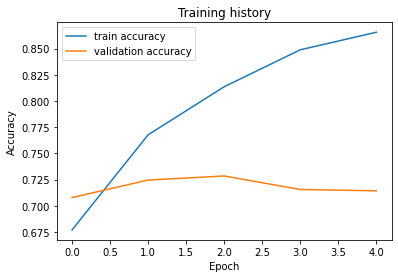

In [23]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1])

In [24]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [25]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [28]:
class_name = ['Not_offensive' ,'Offensive_Untargetede' ,'Offensive_Targeted_Insult_Group' ,
'Offensive_Targeted_Insult_Individual' ,'not-Kannada' ,'Offensive_Targeted_Insult_Other' ]

In [29]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                                      precision    recall  f1-score   support

                       Not_offensive       0.78      0.84      0.81       427
               Offensive_Untargetede       0.00      0.00      0.00        33
     Offensive_Targeted_Insult_Group       0.32      0.32      0.32        44
Offensive_Targeted_Insult_Individual       0.76      0.63      0.69        75
                         not-Kannada       0.74      0.86      0.80       185
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        14

                            accuracy                           0.74       778
                           macro avg       0.43      0.44      0.43       778
                        weighted avg       0.70      0.74      0.72       778

